In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
dr14 = pd.read_csv('Dataset/SDSS_DR14.csv')
dr16 = pd.read_csv('Dataset/SDSS_DR16.csv')
dr17 = pd.read_csv('Dataset/SDSS_DR17.csv')
dr18 = pd.read_csv('Dataset/SDSS_DR18.csv') 
dataframe = pd.concat([dr14, dr16, dr17, dr18], ignore_index=True, sort=False)

In [4]:
df = dataframe.dropna(axis=1, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      310000 non-null  object 
 1   ra         310000 non-null  float64
 2   dec        310000 non-null  float64
 3   u          310000 non-null  float64
 4   g          310000 non-null  float64
 5   r          310000 non-null  float64
 6   i          310000 non-null  float64
 7   z          310000 non-null  float64
 8   run        310000 non-null  int64  
 9   rerun      310000 non-null  int64  
 10  camcol     310000 non-null  int64  
 11  field      310000 non-null  int64  
 12  specobjid  310000 non-null  object 
 13  class      310000 non-null  object 
 14  redshift   310000 non-null  float64
 15  plate      310000 non-null  int64  
 16  mjd        310000 non-null  int64  
 17  fiberid    310000 non-null  int64  
dtypes: float64(8), int64(7), object(3)
memory usage: 42.6+ MB


I need to get rid of values that are not correlated in any way to our class - those are going to be technical informations about observatory, ID numbers etc


In [5]:
df=df.drop(columns=['objid','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'])

Dodatkowo pozbędziemy się fałszywych danych poza zakresami 

In [6]:
df.describe()

,ra,dec,u,g,r,i,z,redshift
count,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000
mean,174.694084,22.097973,19.716598,18.413805,17.770995,17.382543,17.075167,0.300031
std,85.593731,22.738541,18.124083,18.109926,1.907456,18.081449,36.024479,0.579806
min,0.003092,-19.495456,-9999.000000,-9999.000000,9.005167,-9999.000000,-9999.000000,-0.009971
25%,131.354822,1.042457,18.510617,17.143935,16.472307,16.136660,15.908515,0.000107
50%,175.860912,17.145758,19.184505,17.904820,17.357705,17.063675,16.893270,0.070177
75%,223.633481,41.176901,20.162707,19.213520,18.882188,18.631750,18.436143,0.279405
max,359.999810,84.490494,32.781390,31.602240,31.990100,32.141470,29.383740,7.011245


In [7]:
uniques = pd.unique(df['class'])
binary_map = {}
for number, value in enumerate(uniques):
    binary_map[value] = number
df['class'].replace(binary_map,inplace=True)
binary_map

C:\Users\Dominik\AppData\Local\Temp\ipykernel_6772\3310790055.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['class'].replace(binary_map,inplace=True)
C:\Users\Dominik\AppData\Local\Temp\ipykernel_6772\3310790055.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'].replace(binary_

{'STAR': 0, 'GALAXY': 1, 'QSO': 2}

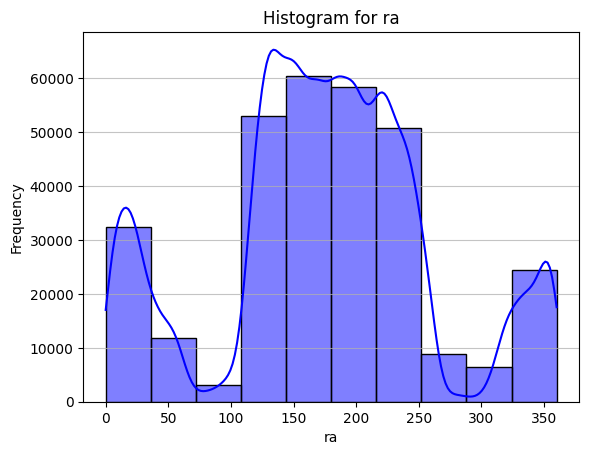

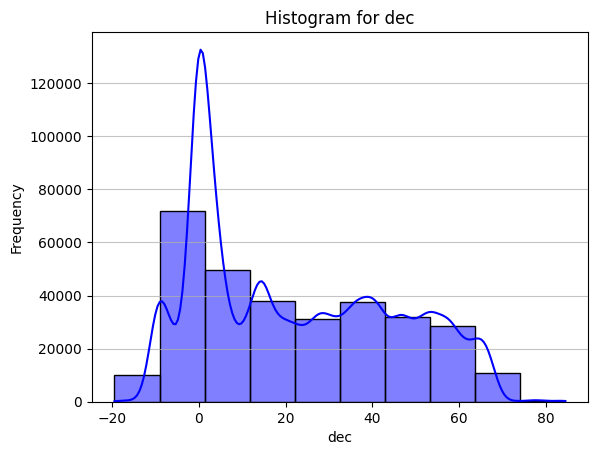

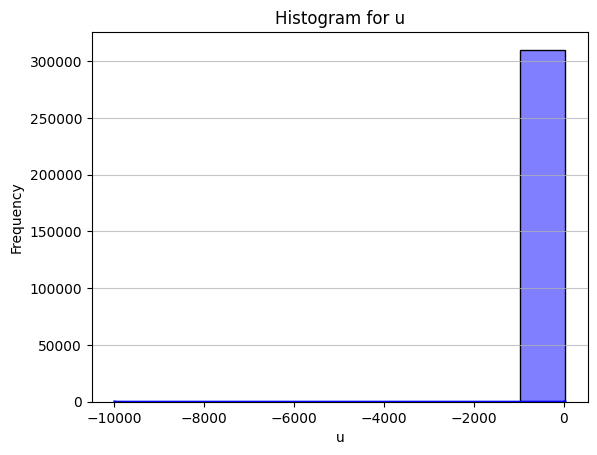

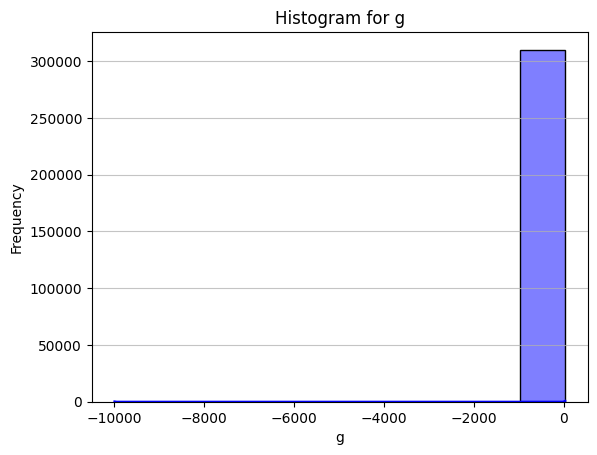

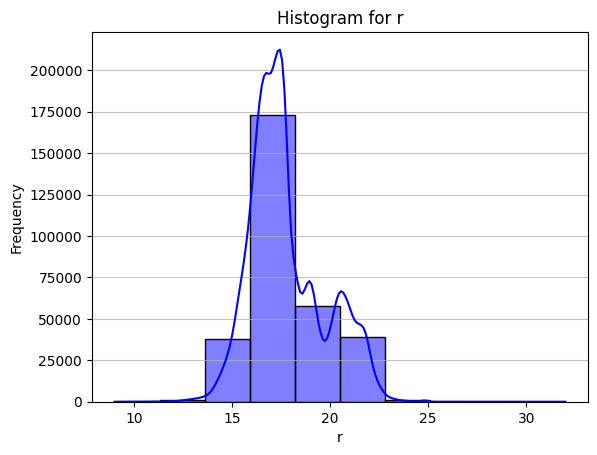

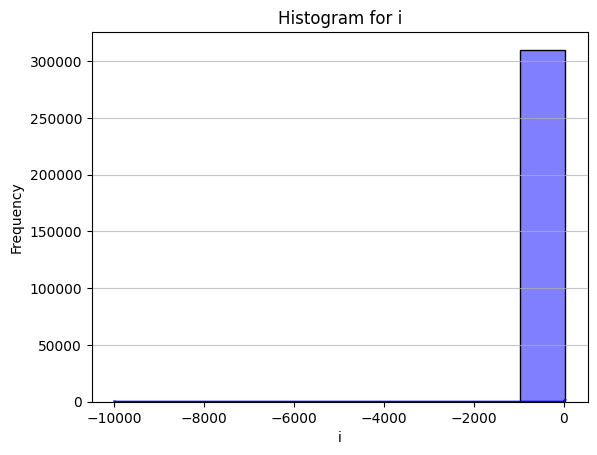

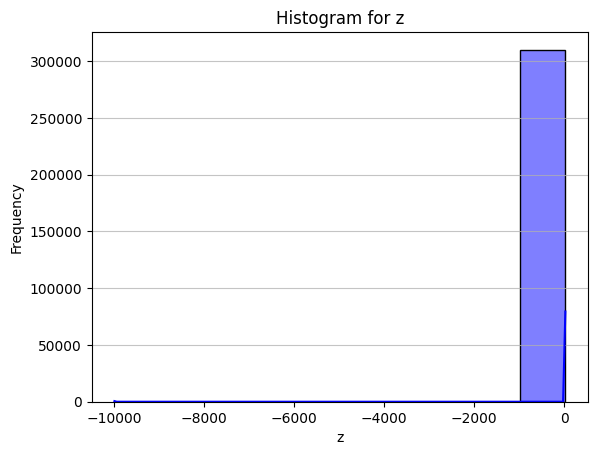

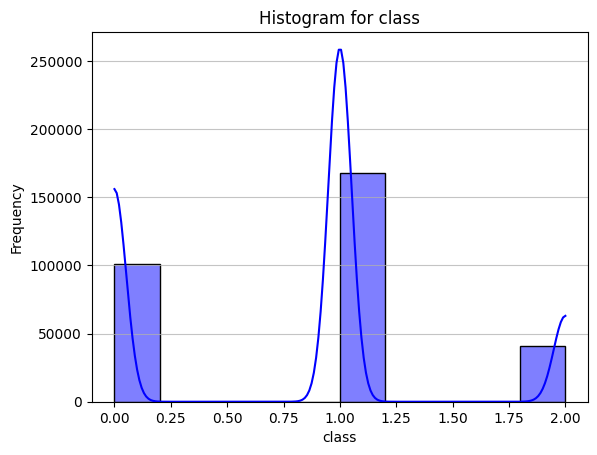

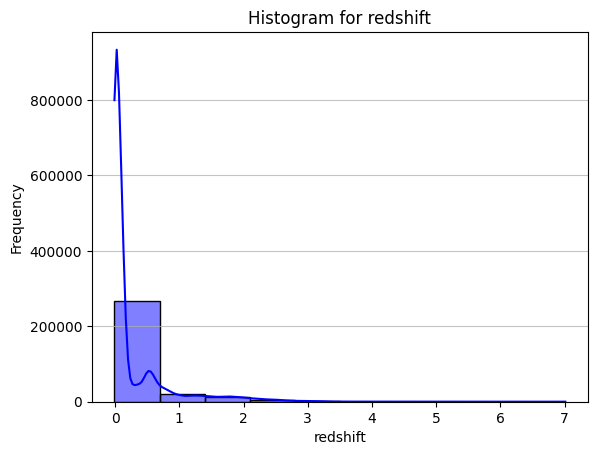

In [8]:
for column in df.select_dtypes(include=['number']).columns:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(df[column], kde=True, bins=10, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Wybieramy zakresy dla poszczególnych kolumn a następnie filtrujemy dane - ryzykujemy utratę niektórych przypadków, ale ewidentnie w zakresie danych są takie które są fizycznie niemożliwe:

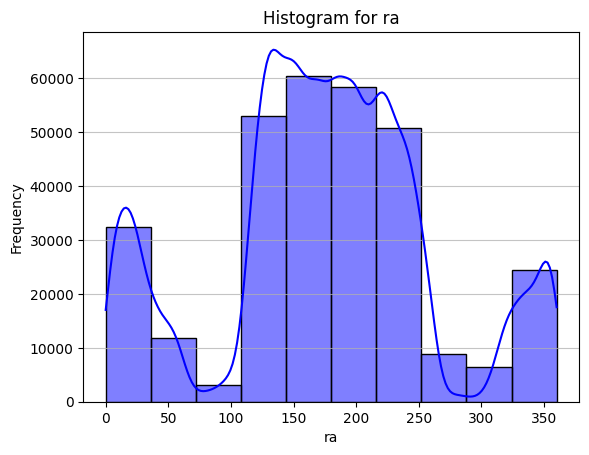

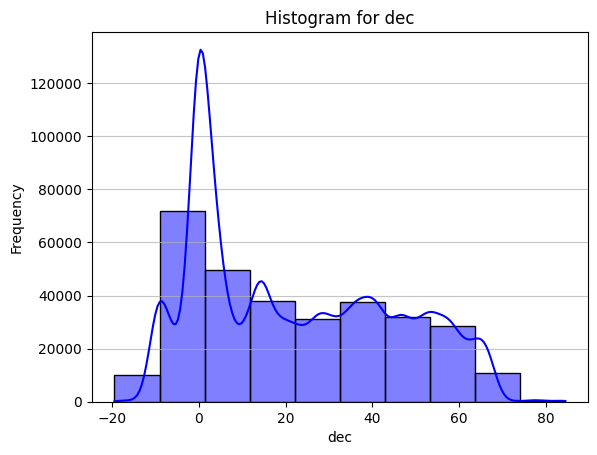

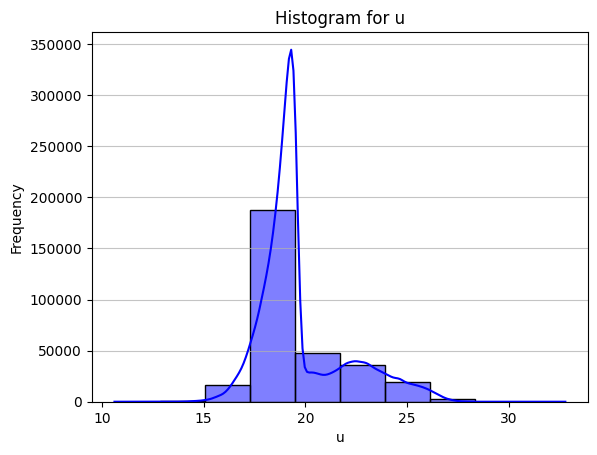

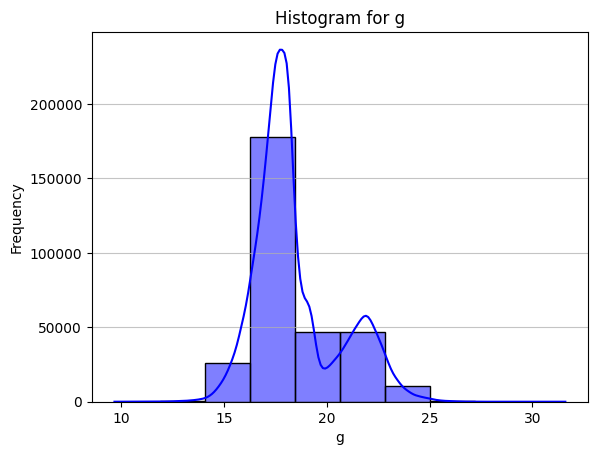

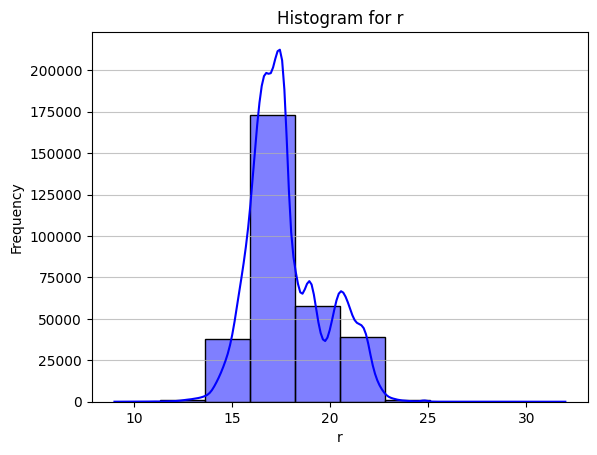

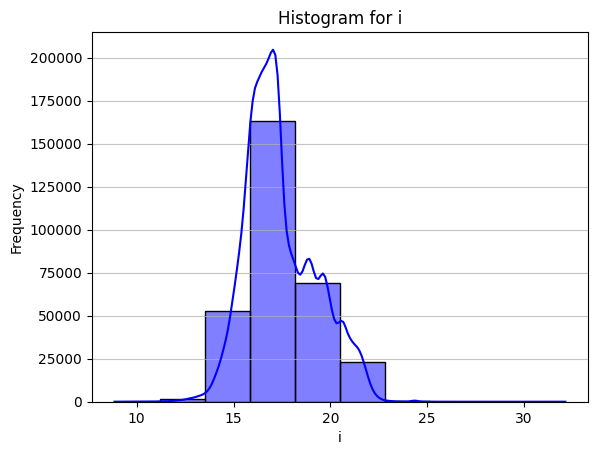

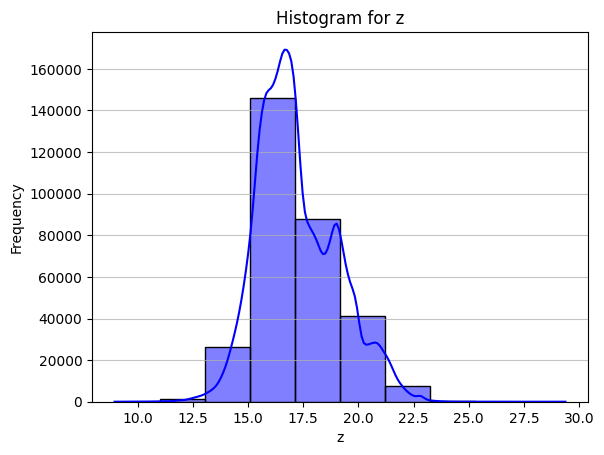

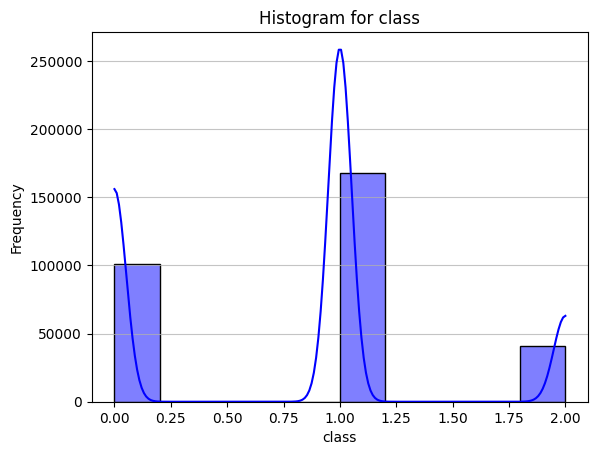

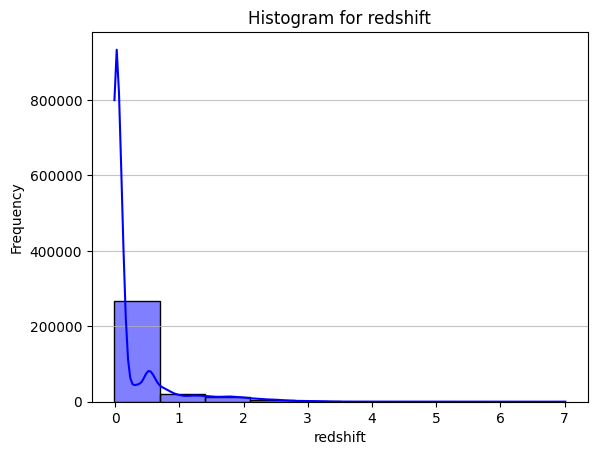

In [9]:
ranges={
"u": (-2000,50),
"g": (-2000,50),
"r": (0,50),
"z": (-2000,50),
}
for column, (min_val, max_val) in ranges.items():
    df = df[(df[column] >= min_val) & (df[column] <= max_val)]

for column in df.select_dtypes(include=['number']).columns:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(df[column], kde=True, bins=10, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Podzielmy dane na dwi oddzielne zestawy:

In [10]:
y=df['class']
x=df.loc[:, df.columns != 'class']

Przeprowadzimy teraz 
## Analizę składowych głównych
zaczniemy od standaryzacji zmiennych


In [11]:
numeric_df = x.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

Teraz przejdziemy do właściwej analizy sprawdzimy dwie rzeczy:
- jak liczba składowych wpływa na całkowitą wariancję
- następnie wybierzemy jedną konkretną liczbę składowych głownych i obliczymy składowe główne dla niej
  

Skumulowana wariancja: [0.61301954 0.74765284 0.86279967 0.95484645 0.99312401 0.99754811
 0.99902642 1.        ]


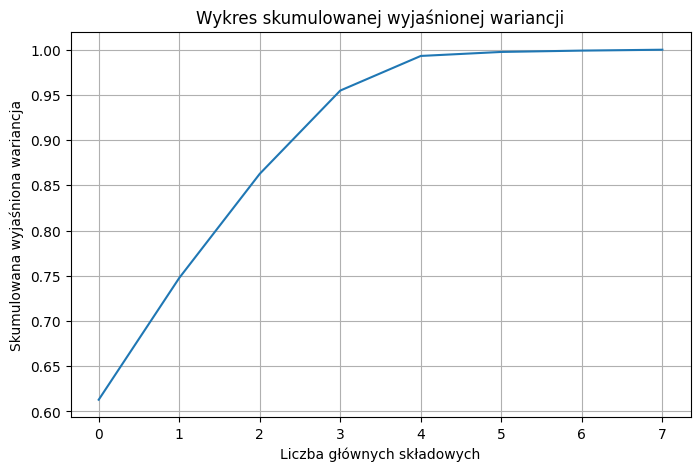

In [12]:
# Tworzenie obiektu PCA, gdzie nie określasz liczby komponentów
pca = PCA()

# Dopasowanie i transformacja danych
pca.fit(scaled_data)

# Sprawdzenie skumulowanej wariancji wyjaśnianej przez kolejne komponenty
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Skumulowana wariancja: {cumulative_variance}")

# Wykres skumulowanej wariancji
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance)
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji')
plt.grid(True)
plt.show()

In [13]:
# Utworzenie obiektu PCA 
n_components=4 #liczba składowych głównych
pca = PCA(n_components)

# Dopasowanie i transformacja danych
principal_components = pca.fit_transform(scaled_data)

# Sprawdzenie ile wariancji wyjaśniają komponenty
explained_variance = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniana przez każdą główną składową: {explained_variance}")

# Utworzenie DataFrame z wynikami analizy PCA (ze zredukowanymi wymiarami)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Uzyskanie macierzy składowych
components = pca.components_

# Tworzenie DataFrame z wynikami
components_df = pd.DataFrame(components, columns=x.select_dtypes(include=[np.number]).columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Wyświetlenie macierzy składowych
print(components_df)

Wariancja wyjaśniana przez każdą główną składową: [0.61301954 0.1346333  0.11514683 0.09204678]
           ra       dec         u         g         r         i         z  \
PC1  0.009132  0.029960  0.393228  0.437499  0.446836  0.440635  0.430594   
PC2  0.712033  0.701017 -0.016387 -0.014054 -0.015194 -0.015238 -0.015914   
PC3 -0.700426  0.707398 -0.050002 -0.026158 -0.011492 -0.002054  0.004495   
PC4  0.045491 -0.085055 -0.357515 -0.198924 -0.076150  0.001872  0.041001   

     redshift  
PC1  0.271574  
PC2  0.020044  
PC3  0.075169  
PC4  0.903230  


Widzimy, że wartość dla ra i dec w pierwszej składowej są bardzo małe, natomiast składowe które je wyjaśniają (2 i 3) bardzo słabo wyjaśniają pozostałe. Sprawdźmy na wszelki wypadek macierz korelacji, bo być może ra i dec są wgl niepotrzebne.

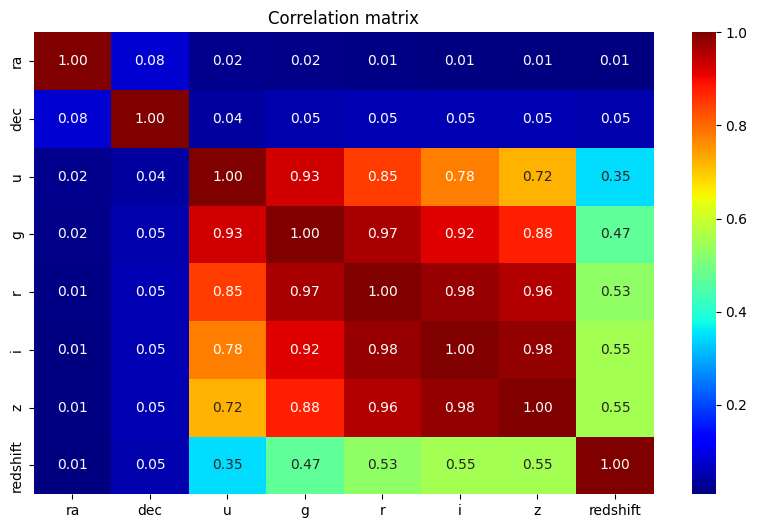

In [14]:
plt.figure(figsize=(10,6))
correlation = pd.concat([x,y],axis=1)
sns.heatmap(x.corr(), annot=True,cmap='jet',fmt='.2f') #jet,copper, coolwarm
plt.title('Correlation matrix')
plt.show()

Wartości ra i dec praktycznie wgl nie pomagają nam w klasyfikacji, pozbędziemy się ich i jeszcz raz ustalimy składowe główne.

Skumulowana wariancja: [0.81672772 0.93976303 0.99083011 0.99673048 0.99870185 1.        ]


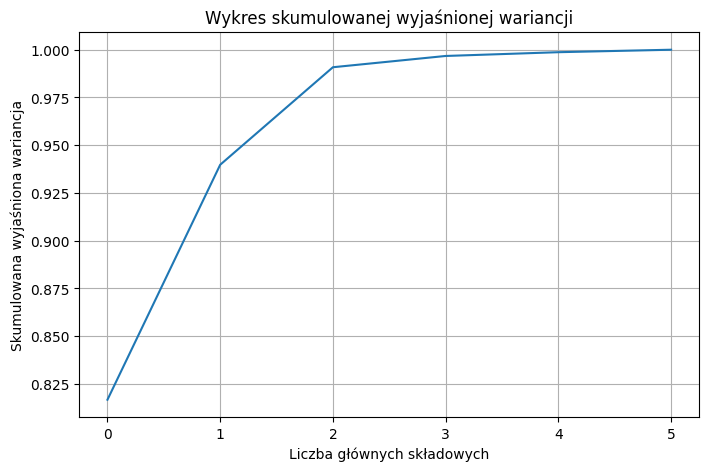

In [15]:
x=x.loc[:, x.columns != 'ra']
x=x.loc[:, x.columns != 'dec']
numeric_df = x.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
# Tworzenie obiektu PCA, gdzie nie określasz liczby komponentów
pca = PCA()

# Dopasowanie i transformacja danych
pca.fit(scaled_data)

# Sprawdzenie skumulowanej wariancji wyjaśnianej przez kolejne komponenty
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Skumulowana wariancja: {cumulative_variance}")

# Wykres skumulowanej wariancji
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance)
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji')
plt.grid(True)
plt.show()

In [16]:
# Utworzenie obiektu PCA 
n_components=2 #liczba składowych głównych
pca = PCA(n_components)

# Dopasowanie i transformacja danych
principal_components = pca.fit_transform(scaled_data)

# Sprawdzenie ile wariancji wyjaśniają komponenty
explained_variance = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniana przez każdą główną składową: {explained_variance}")

# Utworzenie DataFrame z wynikami analizy PCA (ze zredukowanymi wymiarami)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Uzyskanie macierzy składowych
components = pca.components_

# Tworzenie DataFrame z wynikami
components_df = pd.DataFrame(components, columns=x.select_dtypes(include=[np.number]).columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Wyświetlenie macierzy składowych
print(components_df)

Wariancja wyjaśniana przez każdą główną składową: [0.81672772 0.12303531]
            u         g         r         i         z  redshift
PC1  0.393470  0.437721  0.447063  0.440858  0.430811  0.271593
PC2 -0.361179 -0.200761 -0.077152  0.001429  0.041021  0.906426


In [112]:
PCA_values =   x.values @ components_df.T.values
df_PCA_x = pd.DataFrame(PCA_values,columns=[f'PC{i+1}' for i in range(components.shape[0])])
#df_PCA=pd.concat([df_PCA_x,y],axis=1)
df_PCA = df_PCA_x
df_PCA['class'] = pd.DataFrame(y)
df_PCA
df_PCA

,PC1,PC2,class
0,35.645608,-11.038692,0.0
1,36.664800,-10.787298,0.0
2,38.206279,-11.175851,1.0
3,35.380231,-10.321350,0.0
4,35.829161,-10.166418,0.0
...,...,...,...
309991,39.278134,-11.324122,0.0
309992,38.765651,-11.136801,0.0
309993,36.659873,-10.908642,2.0
309994,35.120367,-10.100886,1.0


<Axes: xlabel='PC1', ylabel='PC2'>

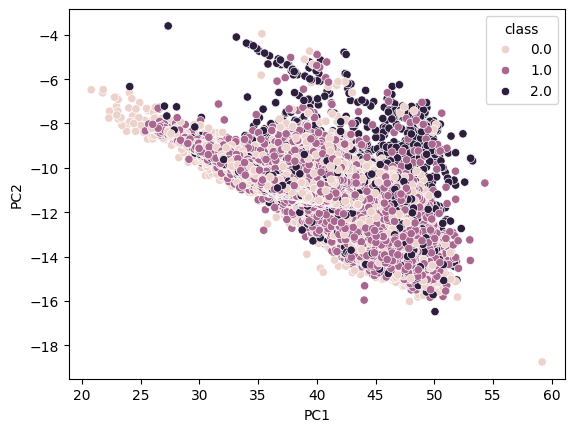

In [113]:
sns.scatterplot(x='PC1',y='PC2',hue='class',data=df_PCA)

<h1 align='center'> Klasteryzacja </h1>

In [3]:
df_PCA.isnull().sum()

NameError: name 'df_PCA' is not defined

In [115]:
t = pd.DataFrame(y)
t

,class
0,0
1,0
2,1
3,0
4,0
...,...
309995,0
309996,0
309997,1
309998,0


In [116]:
y

0         0
1         0
2         1
3         0
4         0
         ..
309995    0
309996    0
309997    1
309998    0
309999    1
Name: class, Length: 309996, dtype: int64

In [ ]:
for i in df_PCA[df_PCA['class'] is None].index:
    df_PCA['class'][i] = y.get(i).value


In [ ]:
pd.DataFrame(y).isnull().sum()

In [ ]:
df_PCA

In [2]:
df_PCA.isnull().sum()

NameError: name 'df_PCA' is not defined